In [1]:
# standard library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# local classes
os.chdir('../')
from TraversalDistance.Graph import Graph
from TraversalDistance.FreeSpaceGraph import FreeSpaceGraph
from TraversalDistance.Visualize import Visualize
from TraversalDistance.BinarySearch import BinarySearch
os.chdir('leaf_data')

In [2]:
df = pd.read_csv('maracuya.csv')

In [3]:
df = df.drop(columns=['plant', 'heteroblasty', 'ontogeny', 'total'])

In [4]:
# divide species into seven classes based on the paper
# https://academic.oup.com/gigascience/article/6/1/giw008/2865207?login=true#supplementary-data
species_classes = {'miniata':6,
    'amethystina':3,
    'alata':5,
    'rubra':1,
    'misera':0,
    'setacea':2,
    'triloba':4,
    'nitida':5,
    'actinia':4,
    'villosa':5,
    'micropetala':1,
    'mucronata':6,
    'maliformis':6,
    'miersii':4,
    'malacophylla':6,
    'gibertii':2,
    'mollissima':2,
    'caerulea':2,
    'gracilis':3,
    'foetida':3,
    'racemosa':5,
    'tenuifila':2,
    'cristalina':6,
    'ligularis':5,
    'cincinnata':2,
    'coccinea':6,
    'hatschbachii':2,
    'morifolia':3,
    'organensis':1,
    'capsularis':1,
    'edmundoi':2,
    'galbana':6,
    'tricuspis':1,
    'pohlii':1,
    'biflora':1,
    'sidifolia':4,
    'suberosa':2,
    'edulis':5,
    'coriacea':0,
    'kermesina':2}

# replace species names with class in dataset
df['species'] = df['species'].map(species_classes)

In [5]:
df.head(10)

,species,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x11,y11,x12,y12,x13,y13,x14,y14,x15,y15
0,4,1.939415,414.812913,-7.047279,385.719915,28.429685,371.115922,65.726986,378.318652,99.227324,...,-108.831734,-1510.662028,563.252807,-424.176777,570.669793,-326.497673,405.345149,249.386171,381.749535,279.209462
1,4,-27.972095,433.154746,-27.127051,417.953521,-17.138482,393.213241,21.438983,394.733759,42.800256,...,28.713845,-1468.443026,525.022693,-425.378430,538.426886,-343.900676,489.936964,124.340189,467.627131,173.870135
2,4,-43.242816,430.053913,-39.277936,409.976781,-34.239161,376.468073,4.770596,377.631881,19.758407,...,120.698695,-1462.301694,546.694706,-517.910591,557.727421,-406.283139,488.911001,155.339518,460.348932,210.137903
3,4,-36.082509,416.832663,-30.527203,394.236217,-19.829324,359.869763,13.246641,361.064598,25.471213,...,-58.899860,-1385.313503,535.019483,-519.980964,617.977373,-346.868643,517.511348,207.452944,483.026127,261.141674
4,4,-7.724386,362.852233,-18.024917,347.266408,-16.965580,316.096657,18.166718,313.986527,26.485501,...,82.426785,-1493.947554,572.248040,-473.575088,591.964194,-391.158971,440.811250,275.545461,392.206108,308.648330
5,4,-16.055860,392.188151,-19.701117,368.256849,-9.515832,342.898888,27.067663,356.380453,37.014086,...,10.536848,-1424.586489,583.337495,-406.982599,603.598228,-307.765333,556.231575,146.518317,536.364320,211.098302
6,4,-34.824296,373.196015,-37.809982,356.192512,-36.947907,316.275227,13.351338,310.079425,15.471099,...,0.618198,-1459.041832,617.465742,-398.390383,641.548306,-285.920461,500.624211,191.235877,465.752611,237.127426
7,4,-0.098964,362.559497,-3.733424,339.677463,0.430087,311.153987,45.967204,320.472914,61.537506,...,-83.152149,-1413.747737,644.222662,-358.288967,681.068810,-276.978490,504.490160,210.448210,449.125344,259.963456
8,4,15.427561,361.231239,2.307194,343.790835,8.969152,315.380138,54.676368,305.552733,71.741267,...,19.285643,-1418.757910,632.358628,-445.899448,658.847353,-352.526786,455.654742,263.676606,394.493425,306.790393
9,4,-15.812526,408.515549,-20.146761,392.283320,-13.664190,358.731703,27.468388,381.445451,38.299236,...,-39.080934,-1260.294638,584.556000,-442.321698,619.207411,-381.727365,606.390413,142.082100,558.795625,215.690020


In [6]:
# edges to build graph
edges = {(1, 2),
    (2, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (6, 1),
    (1, 7),
    (2, 7),
    (2, 9),
    (3, 9),
    (3, 11),
    (4, 11),
    (4, 13),
    (5, 13),
    (5, 15),
    (6, 15),
    (7, 8),
    (8, 9),
    (9, 10),
    (10, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (14, 15)
}

x_headers = [f'x{i}' for i in range(1, 16)]
y_headers = [f'y{i}' for i in range(1, 16)]

min_max_scale = lambda s: (s - s.min()) / (s.max() - s.min())

# function to convert observation into Graph object
def observation_to_graph(row):
    
    x_row, y_row = row[x_headers], row[y_headers]
    x_scaled, y_scaled = min_max_scale(x_row), min_max_scale(y_row)
    
    graph = Graph()

    for i, (x_header, y_header) in enumerate(zip(x_headers, y_headers), 1):
        x, y = x_scaled[x_header], y_scaled[y_header]
        graph.addNode(i, x, y)
        
    for i, edge in enumerate(edges, 1):
        graph.connectTwoNodes(i, edge[0], edge[1])
            
    return graph

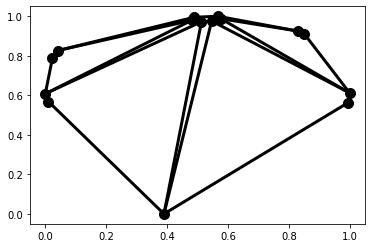

In [7]:
# First observation example. 
row1 = df.iloc[0]
graph1 = observation_to_graph(row1)
graph1.Plot2MatPlotLib()

In [8]:
graphs = list()

# remove head for full dataset
for index, row in df.head(10).iterrows():
    graph = observation_to_graph(row)
    graphs.append((row['species'], graph))

In [14]:
graph_1, graph_2 = graphs[0][1], graphs[0][1]
binary_search = BinarySearch(graph_1, graph_2, left=0, right=1, precision=0.01)
binary_search.search()

Projeciton check if epsilon is reachable: True
| 0 -- 0.5 -- 1 | 

Projeciton check if epsilon is reachable: False
| 0 -- 0.25 -- 0.5 | 

Projeciton check if epsilon is reachable: False
| 0.25 -- 0.375 -- 0.5 | 

Projeciton check if epsilon is reachable: True
| 0.375 -- 0.4375 -- 0.5 | 

Projeciton check if epsilon is reachable: True
| 0.375 -- 0.40625 -- 0.4375 | 

Projeciton check if epsilon is reachable: True
| 0.375 -- 0.390625 -- 0.40625 | 

Projeciton check if epsilon is reachable: True
| 0.375 -- 0.3828125 -- 0.390625 | 

Epsilon checks precision: 0.3828125


0.3828125

In [15]:
visual = Visualize(g1=graph_1, g2=graph_2, epsilon=binary_search.epsilon)

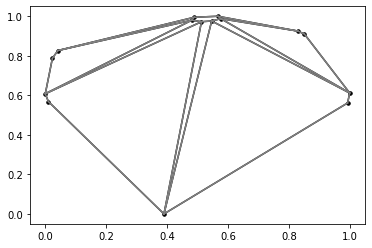

In [16]:
visual.plot_graphs()

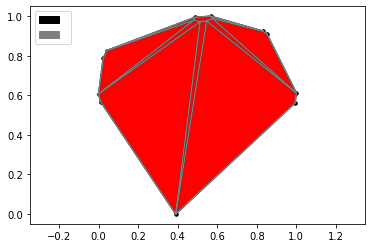

In [17]:
visual.plot_freespace_cells()

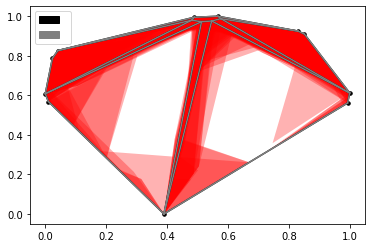

In [18]:
visual.plot_cell_boundaries()